In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd

from os import listdir, mkdir, getcwd
from os.path import isfile, join, basename, isdir

from sys import platform
if platform == "linux" or platform == "linux2":
    import ROOT
    %jsroot off

from analysis.convert_directory import convert_directory
from analysis.split_event_tree import split_event_tree,ttype_column
from analysis.calc import calc_nll

Welcome to JupyROOT 6.26/10


In [2]:
source_path = join("/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/", "scripts") # getcwd()
output_path = join(source_path, ".npy")

# Convert all .root files inside source_path to .npy files in output_path
# Note: Data in .root files is organized in a tree structure. We will use the name "dataTree" here
convert_directory(source_path, "dataTree", output_path)

Skipping file <compare_mcparticle.root> (exists)
Skipping file <compare_reco.root> (exists)
Skipping file <compare_truejet.root> (exists)


In [3]:
files = list(map(lambda e: join(output_path, e), listdir(output_path)))
files

['/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/scripts/.npy/compare_mcparticle.root.npy',
 '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/scripts/.npy/compare_reco.root.npy',
 '/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/scripts/.npy/compare_truejet.root.npy']

In [4]:
def import_data(path):
    # Load numpy file to pandas dataframe
    df = pd.DataFrame(np.load(path, allow_pickle=True))
    
    # For total ME, sum over helicity final states (for Z boson with spin s=1, 2s+1=3 possibilities, s_z = -1,0,1), average over helicity initial states (RL, LR)
    # Here, however, we just want to summarize the 
    df["zzh_sigmalr"] = 1/2 * ( df["zzh_sigmalrl"] + df["zzh_sigmalrr"] )
    
    # Add a column called true_type which is either "zhh" or "zzh", based on the columns "is_zhh" and "is_zzh"
    ttype_column(df)
    
    return df

# Filters out only events with ZHH/ZZH->µµbar+qqbar+qqbar AND without any error 
def filter_data(df):
    df = df[(df["error_code"] == 0) & (df["zhh_sigma"] > 0) & (df["zzh_sigma"] > 0)]
    df = df.copy()
    df.reset_index(drop=True, inplace=True)
    
    return df

In [5]:
# Import the complete generator-level(MCParticle)-, reconstruction-(reco) and truejet-datasets 
raw_mcparticle = import_data(files[0])
raw_reco       = import_data(files[1])
raw_truejet    = import_data(files[2])

# Filter the table to only contain entries without errors (error_code = 0) and with matrix elements > 0 for ZHH and ZZH (zhh_sigmalr and zzh_sigmalr)
data_mcparticle = filter_data(raw_mcparticle)
data_reco       = filter_data(raw_reco)
data_truejet    = filter_data(raw_truejet)

# Calculate the negative log likelihood based on the matrix elements 
data_mcparticle = calc_nll(data_mcparticle)
data_reco       = calc_nll(data_reco)
data_truejet    = calc_nll(data_truejet)

In [6]:
data_reco.columns

Index(['run', 'event', 'error_code', 'is_zhh', 'is_zzh', 'passed_preselection',
       'true_h1_decay_pdg', 'true_h2_decay_pdg', 'true_z2_decay_pdg',
       'h1_decay_pdg', 'h2_decay_pdg', 'z2_decay_pdg', 'zhh_sigma',
       'zhh_sigmall', 'zhh_sigmalr', 'zhh_sigmarl', 'zhh_sigmarr', 'zhh_mz',
       'zhh_mhh', 'zhh_mzhh', 'zhh_phi', 'zhh_phif', 'zhh_phih',
       'zhh_costheta', 'zhh_costhetaf', 'zhh_costhetah', 'zzh_sigma',
       'zzh_sigmalll', 'zzh_sigmallr', 'zzh_sigmalrl', 'zzh_sigmalrr',
       'zzh_sigmarrr', 'zzh_sigmarrl', 'zzh_sigmarlr', 'zzh_sigmarll',
       'zzh_mz1', 'zzh_mz2', 'zzh_mzz', 'zzh_mzzh', 'zzh_mh', 'zzh_phi',
       'zzh_phiz', 'zzh_phiz1f', 'zzh_phiz2f', 'zzh_costheta', 'zzh_costhetaz',
       'zzh_costhetaz1f', 'zzh_costhetaz2f', 'zzh_sigmalr', 'true_type',
       'zhh_nll', 'zzh_nll', 'llr'],
      dtype='object')

Comparing all (raw) and filtered (data) events

<Axes: xlabel='error_code', ylabel='count'>

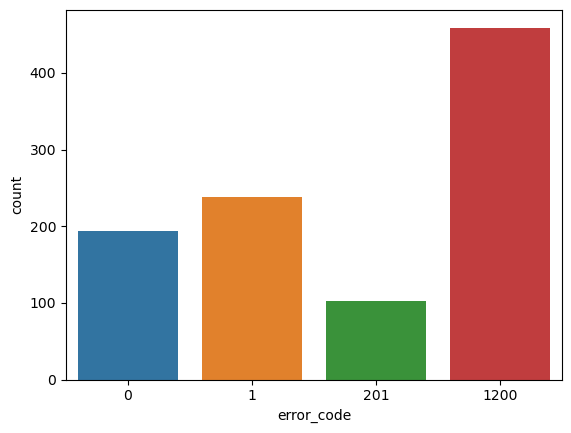

In [7]:
sns.countplot(raw_truejet, x="error_code")

Text(0.5, 1.0, 'Filtered')

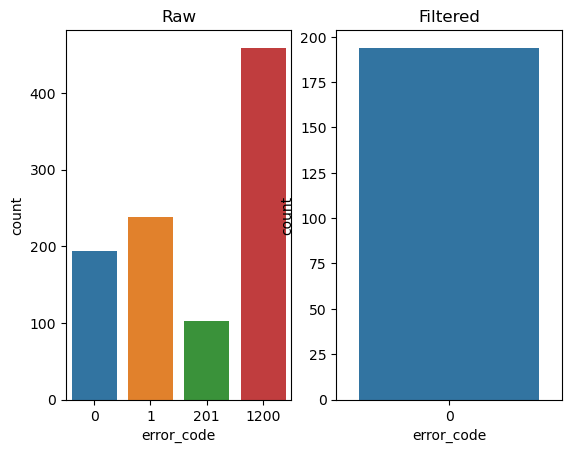

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig1 = sns.countplot(raw_truejet, x="error_code", ax=ax1)
fig1.set_title("Raw")
fig2 = sns.countplot(data_truejet, x="error_code", ax=ax2)
fig2.set_title("Filtered")

In [9]:
data_truejet["zhh_sigmalr"]

0      1.121969e-25
1      1.220570e-23
2      8.798139e-28
3      1.487639e-27
4      8.420216e-25
           ...     
189    8.435759e-24
190    5.316890e-26
191    6.093439e-26
192    3.631844e-25
193    2.591996e-25
Name: zhh_sigmalr, Length: 194, dtype: float64

<Axes: xlabel='zzh_nll', ylabel='Count'>

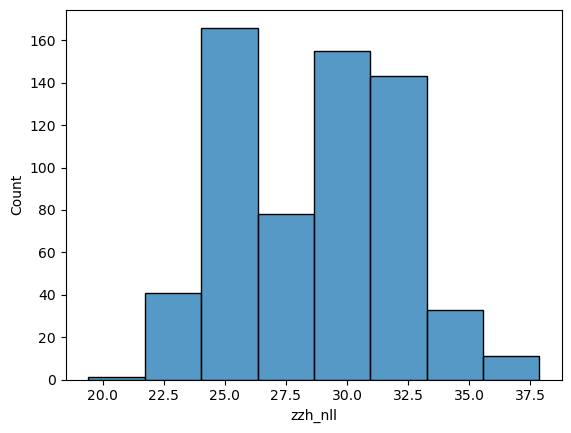

In [13]:
sns.histplot(data_mcparticle, x="zzh_nll", bins=8)

<Axes: xlabel='h1_decay_pdg', ylabel='count'>

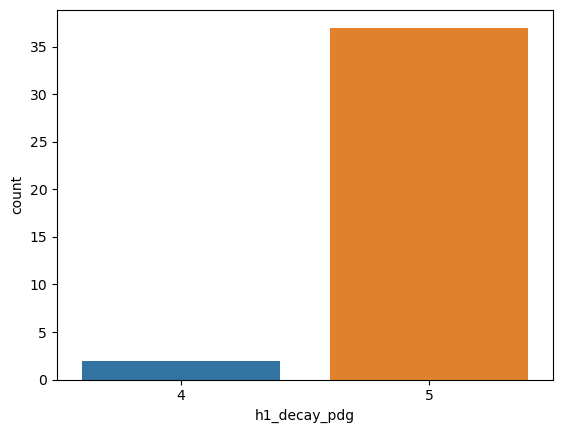

In [15]:
sns.countplot(data_truejet[(data_truejet["is_zzh"] == 1) & (data_truejet["error_code"] == 0)], x="h1_decay_pdg")

<Axes: xlabel='zhh_costhetaf', ylabel='Count'>

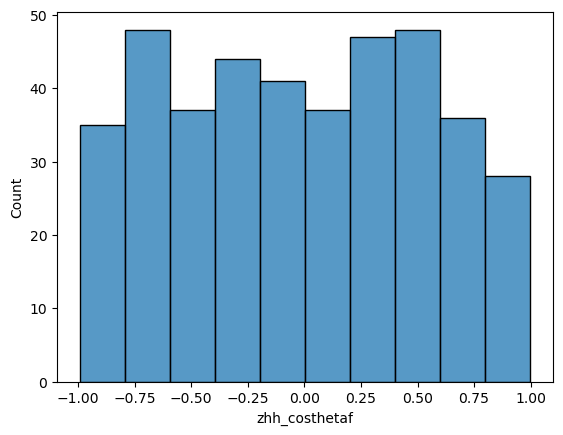

In [16]:
sns.histplot(data_mcparticle[data_mcparticle["is_zhh"] == 1]["zhh_costhetaf"])

<Axes: xlabel='zzh_costhetaz', ylabel='Count'>

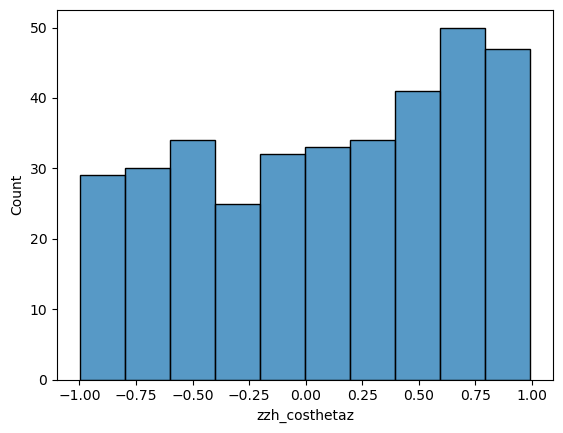

In [17]:
sns.histplot(data_mcparticle[data_mcparticle["is_zzh"] == 1]["zzh_costhetaz"])

1. MCTruth

In [77]:
true_zzh = data[(data["is_zzh"] == 1) & (data["zhh_sigma"] > 0) & (data["zzh_sigma"] > 0)].copy()
true_zhh = data[(data["is_zhh"] == 1) & (data["zhh_sigma"] > 0) & (data["zzh_sigma"] > 0)].copy()

true_zzh = calc_nll(true_zzh, "zhh_sigmalr", "zzh_sigmalr")
true_zhh = calc_nll(true_zhh, "zhh_sigmalr", "zzh_sigmalr")

In [43]:
def plot_hist(data, x, labels=None, colorpalette=None, bins=128, xlabel="", ylabel="", units="", normalize=False, title="Likelihood-Analysis"):
    # Get colorpalette
    pal = colorpalette if colorpalette is not None else [2,4,5,6,7,8,9,10,11]

    # Autoscaling
    g_min = 0.98*data[x].min().min()
    g_max = 1.02*data[x].max().max()
    
    canv = ROOT.TCanvas("c_name", "c_title", 800, 600)
    
    # Create histograms
    hists = []
    for i in range(0, len(x)):
        column = x[i]
        h_title = title if i == 0 else ""
        h_name  = labels[i] if labels is not None else column
        
        hists.append(ROOT.TH1D(h_name, h_title, bins, g_min, g_max))

    xaxis = hists[0].GetXaxis()
    xaxis.SetTitle(xlabel + (" [" + units + "]" if units != "" else ""))
    
    ylabel = "Normalized" if (normalize and ylabel == "") else ""
    yaxis = hists[0].GetYaxis()
    yaxis.SetTitle(ylabel)
    
    #ROOT.gStyle.SetErrorX(0)

    # Assume hist_zhh and hist_zzh are of same size
    for j in range(0, len(x)):
        for i in range(0, len(data[x[0]])):
                hists[j].Fill(data[x[j]][i])
    
    # Get maximum bin value for scaling
    maxval = 0
    if normalize:
        for hist in hists:
            maxval = max(maxval, hist.GetMaximum()/hist.Integral())
            hist.Scale(1/hist.Integral())
    else:
        for hist in hists:
            maxval = max(maxval, hist.GetMaximum())
        
    hists[0].SetAxisRange(0., 1.02*maxval, "Y")

    # Adjust histogram styling
    for i in range(0, len(hists)):        
        hist  = hists[i]
        color = pal[i]
        
        hist.SetFillStyle(3004)
        hist.SetFillColorAlpha(color, 0.35)
        hist.SetLineWidth(2)
        hist.SetLineColor(color)
    
    # Draw histograms
    for i in range(0, len(hists)):        
        hist  = hists[i]
        hist.Draw("HIST" if i == 0 else "HISTSAMES")
    
    canv.Draw()
    
    ROOT.gPad.Update()

    # Adjust styling of statsboxes
    for i in range(0, len(hists)):
        hist = hists[i]
        sb = hist.FindObject("stats")
        
        hist.GetListOfFunctions().Remove(sb)
        hist.SetStats(0)
    
        sb.SetX1NDC(0.7)
        sb.SetX2NDC(0.95)
        sb.SetY1NDC(0.75 - i*0.15)
        sb.SetY2NDC(0.88 - i*0.15)
        sb.SetLineColor(pal[i])
        sb.SetTextColor(pal[i])
    
        sb.Draw()

    canv.Modified()
    canv.Update()

    return [canv, hists]

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: ZHH MCTruth (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ZZH MCTruth (Potential memory leak).


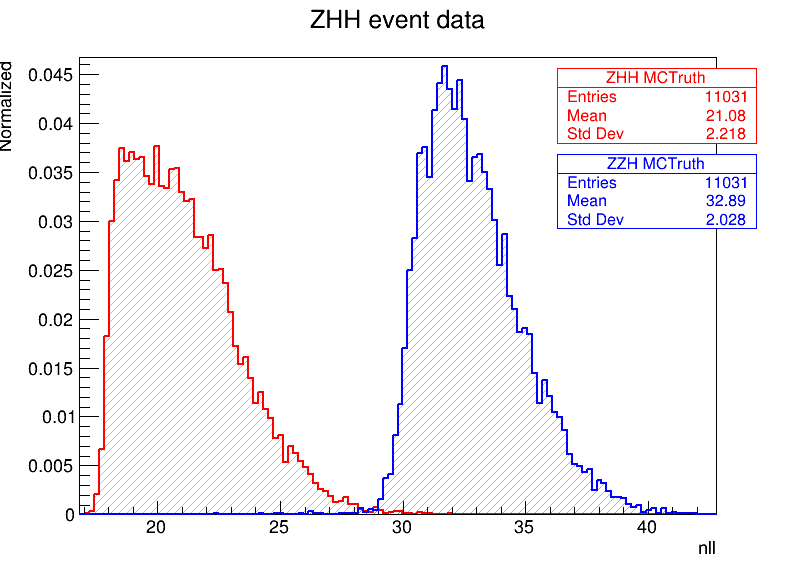

In [78]:
plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH MCTruth", "ZZH MCTruth"], xlabel="nll")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: ZHH MCTruth (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ZZH MCTruth (Potential memory leak).


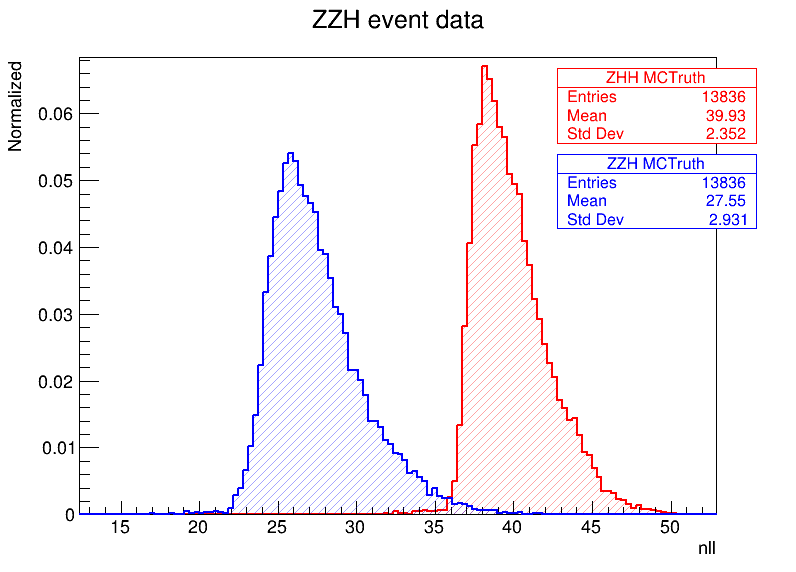

In [79]:
plot_hist(true_zzh, x = ["zhh_nll", "zzh_nll"], title="ZZH event data", normalize=True, labels=["ZHH MCTruth", "ZZH MCTruth"], xlabel="nll")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: ZHH event data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ZZH event data (Potential memory leak).


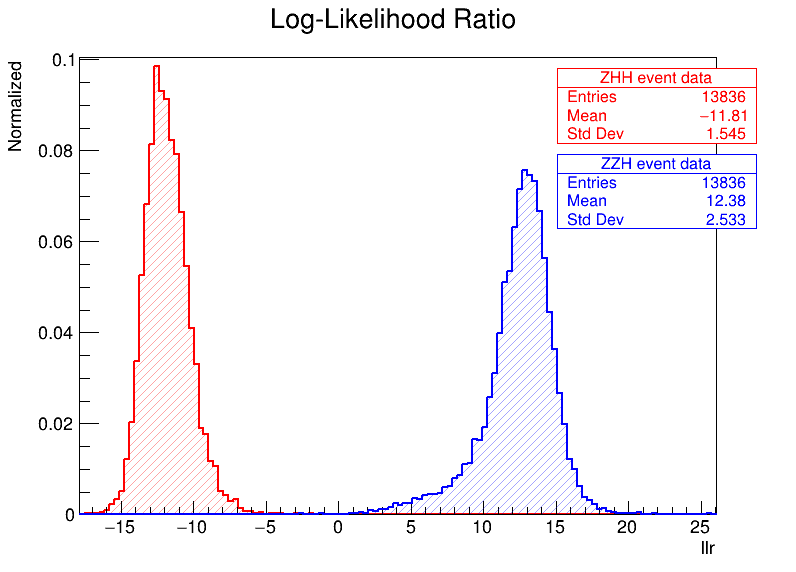

In [80]:
plot_hist(pd.DataFrame({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] }), x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="Log-Likelihood Ratio", normalize=True, xlabel="llr")

2. RefinedJets

In [86]:
true_zzh = data_jet[(data_jet["is_zzh"] == 1) & (data_jet["zhh_sigmalr"] > 0) & (data_jet["zzh_sigmalr"] > 0)].copy()
true_zhh = data_jet[(data_jet["is_zhh"] == 1) & (data_jet["zhh_sigmalr"] > 0) & (data_jet["zzh_sigmalr"] > 0)].copy()

true_zzh = calc_nll(true_zzh, "zhh_sigmalr", "zzh_sigmalr")
true_zhh = calc_nll(true_zhh, "zhh_sigmalr", "zzh_sigmalr")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: ZHH Reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ZZH Reco (Potential memory leak).


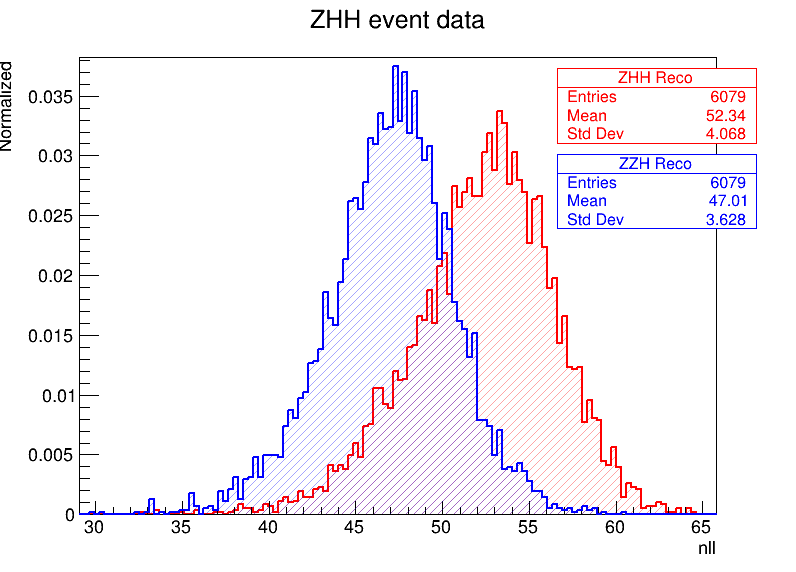

In [91]:
plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: ZHH Reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ZZH Reco (Potential memory leak).


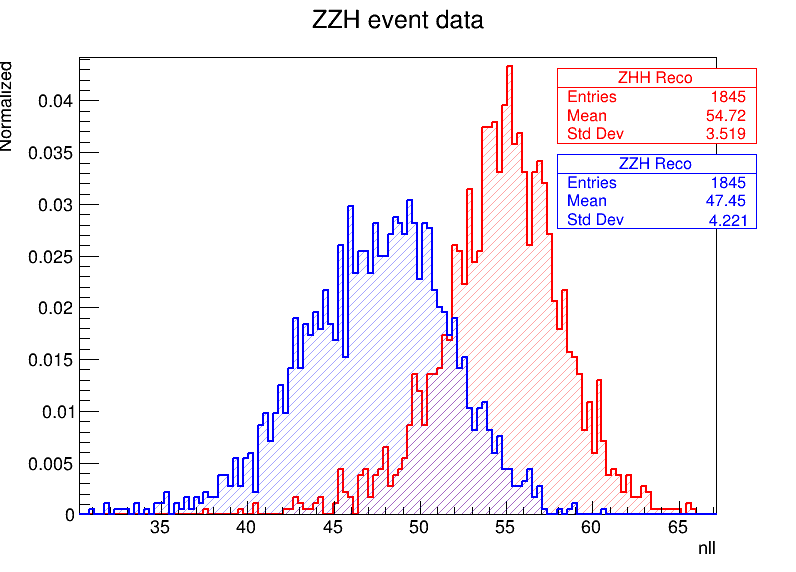

In [92]:
plot_hist(true_zzh, x = ["zhh_nll", "zzh_nll"], title="ZZH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: ZHH event data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ZZH event data (Potential memory leak).


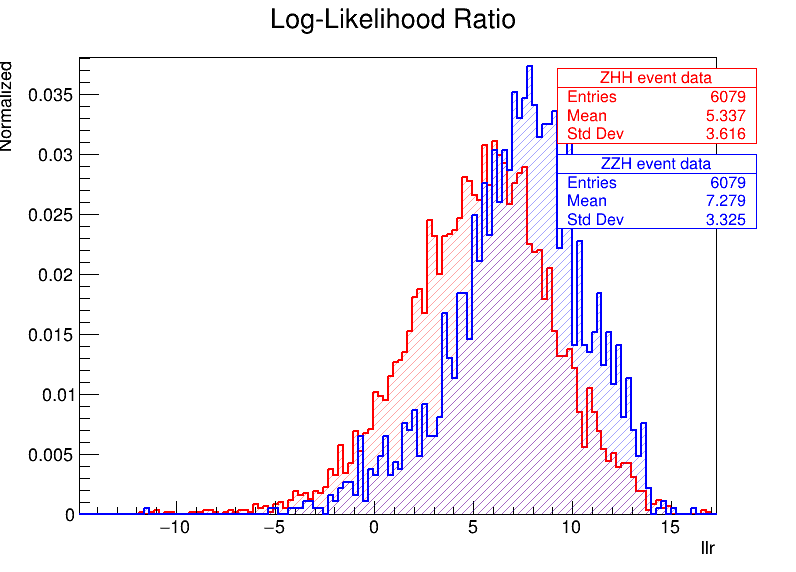

In [94]:
plot_hist(pd.DataFrame({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] }), x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="Log-Likelihood Ratio", normalize=True, xlabel="llr")

Other

<Axes: xlabel='zhh_costhetah', ylabel='Count'>

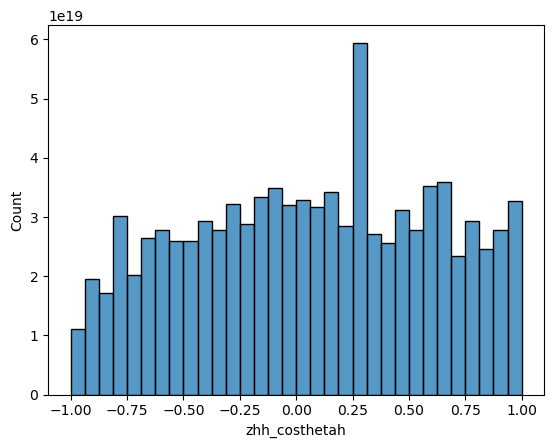

In [56]:
sns.histplot(x=data2["zhh_costhetah"], bins=32, weights=np.array(1/data2["zhh_sigma"]))

<Axes: xlabel='zzh_costheta', ylabel='zzh_sigma'>

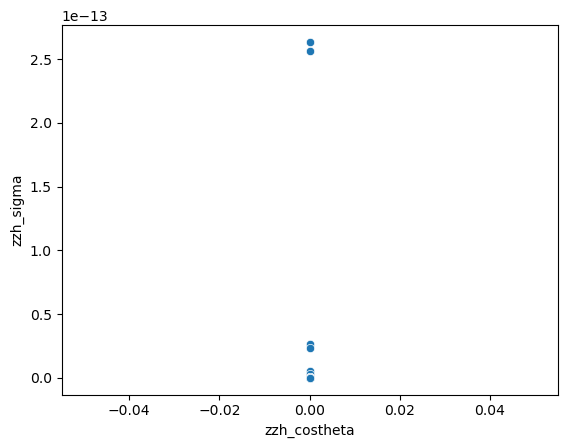

In [71]:
sns.scatterplot(x=data2["zzh_costheta"], y=data2["zzh_sigma"])

<Axes: xlabel='zzh_costhetaz2f', ylabel='Count'>

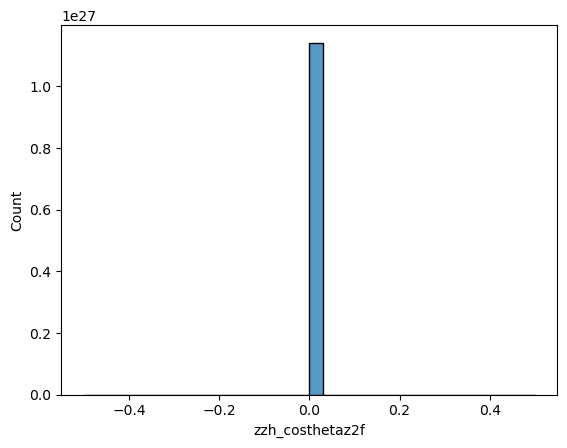

In [63]:
sns.histplot(x=data2["zzh_costhetaz2f"], bins=32, weights=np.array(1/data2["zzh_sigma"]))

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: ZHH MCTruth (Red) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ZZH MCTruth (Blue) (Potential memory leak).


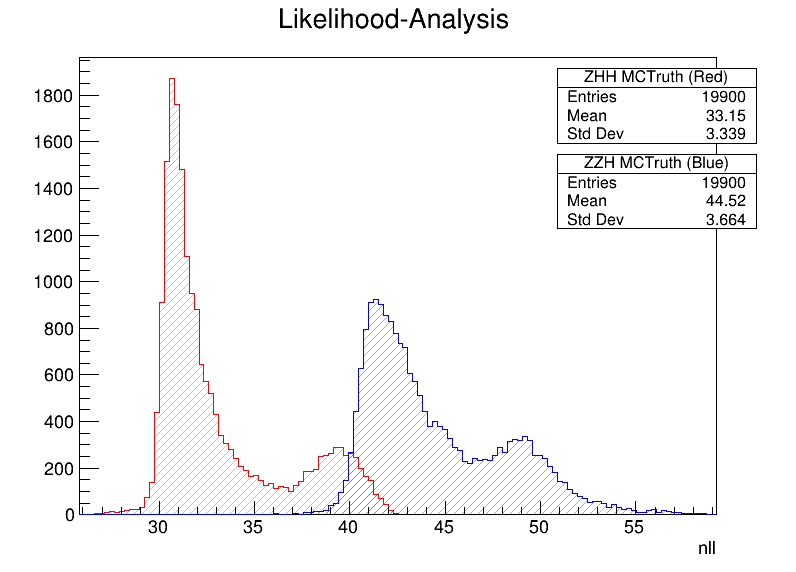

In [50]:
calc_nll(data2)
plot_nll(data2["zhh_nll"], data2["zzh_nll"])

In [9]:
data["h1z2_decay_pdg"] = data["h1_decay_pdg"] + data["z2_decay_pdg"]

Text(0.5, 1.0, 'MCParticle data')

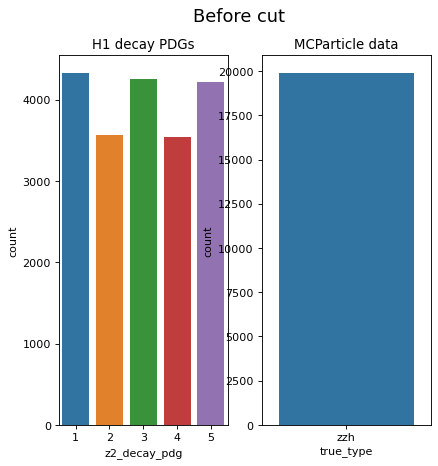

In [14]:
d = data
fig, axes = plt.subplots(1,2, figsize=(6, 6), dpi=80)
fig.suptitle("Before cut", fontsize=16)

ax = sns.countplot(d, x="z2_decay_pdg", ax=axes[0])
ax.set_title("H1 decay PDGs")

ax = sns.countplot(d, x="true_type", ax=axes[1])
ax.set_title("MCParticle data")

Important: Unaccounted/"thrown away" events: H->gg,gammagamma,ZZ,W+W-

In [12]:
# Show amount of thrown-away entries
selection = data[(data["zhh_sigma"] <= 0) | (data["zzh_sigma"] <= 0)]
print("Throwing away", len(selection)/len(data)*100, "% of all events")

Throwing away 16.28391959798995 % of all events


In [14]:
# Applying cut
data_cut = data.loc[(data["zhh_sigma"] > 0) & (data["zzh_sigma"] > 0)].copy()
data_cut.shape

data_jet_cut = data_jet.loc[(data_jet["zhh_sigma"] > 0) & (data_jet["zzh_sigma"] > 0)].copy()
data_jet_cut.shape

(6276, 78)

In [42]:
data_cut["zhh_nll"] = -np.log(data_cut["zhh_sigma"])
data_cut["zzh_nll"] = -np.log(data_cut["zzh_sigma"])
data_cut["llr"]     = np.log(data_cut["zzh_sigma"]/data_cut["zhh_sigma"])
data_cut.reset_index(drop=True, inplace=True)

data_jet_cut["zhh_nll"] = -np.log(data_jet_cut["zhh_sigma"])
data_jet_cut["zzh_nll"] = -np.log(data_jet_cut["zzh_sigma"])
data_jet_cut["llr"]     = np.log(data_jet_cut["zzh_sigma"]/data_jet_cut["zhh_sigma"])
data_jet_cut.reset_index(drop=True, inplace=True)

Text(0.5, 0, 'ln(L_0/L_1)')

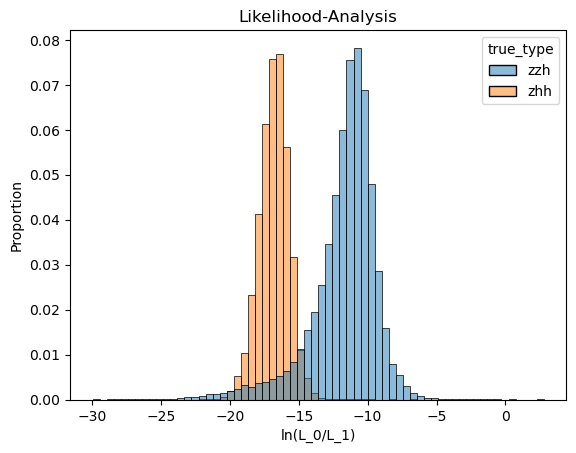

In [16]:
ax = sns.histplot(data_cut, x="llr", hue="true_type", bins=64, stat="proportion")
ax.set_title("Likelihood-Analysis")
ax.set_xlabel("ln(L_0/L_1)")

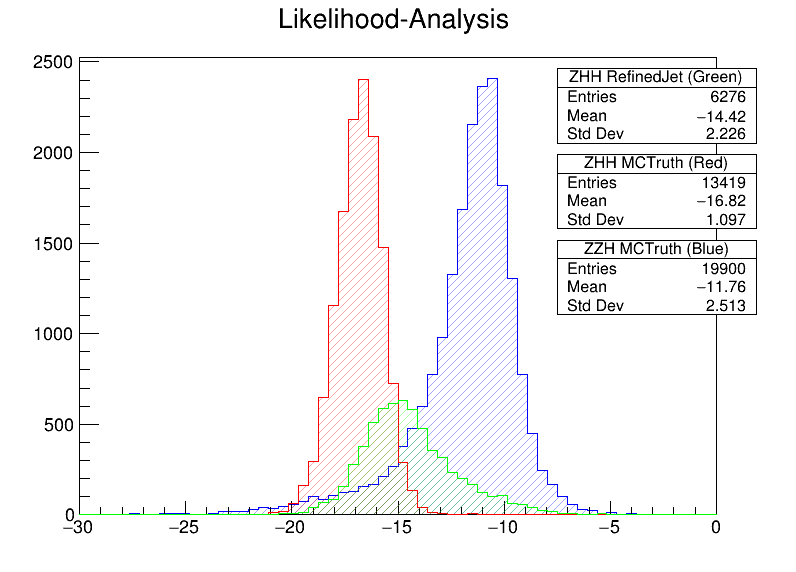

In [14]:
canv = ROOT.TCanvas("c_name", "c_title", 800, 600)
hist_zzh = ROOT.TH1D("ZZH MCTruth (Blue)", "Likelihood-Analysis", 64, -30, 0)
hist_zhh = ROOT.TH1D("ZHH MCTruth (Red)", "Likelihood-Analysis", 64, -30, 0)
hist_zhh_jet = ROOT.TH1D("ZHH RefinedJet (Green)", "Likelihood-Analysis", 64, -30, 0)

llr = data_cut["llr"]
ttype = data_cut["true_type"]
for i in range(0, len(llr)):
    if ttype[i] == "zzh":
        hist_zzh.Fill(llr[i])
    elif ttype[i] == "zhh":
        hist_zhh.Fill(llr[i])

llr = data_jet_cut["llr"]
ttype = data_jet_cut["true_type"]
for i in range(0, len(llr)):
    hist_zhh_jet.Fill(llr[i])

hist_zzh.SetFillStyle(3004)
hist_zzh.SetFillColorAlpha(ROOT.kBlue, 0.35)
hist_zzh.SetLineColor(ROOT.kBlue)

hist_zhh.SetFillStyle(3004)
hist_zhh.SetFillColorAlpha(ROOT.kRed, 0.35)
hist_zhh.SetLineColor(ROOT.kRed)

hist_zhh_jet.SetFillStyle(3004)
hist_zhh_jet.SetFillColorAlpha(ROOT.kGreen, 0.35)
hist_zhh_jet.SetLineColor(ROOT.kGreen)

hist_zzh.Draw()
hist_zhh.Draw("sames")
hist_zhh_jet.Draw("sames")
canv.Draw()

ROOT.gPad.Update()

# Adjust statsbox; possible only after drawing
# See https://root.cern.ch/doc/master/classTPaveStats.html
statsbox_zhh_jet = hist_zhh_jet.FindObject("stats")
statsbox_zhh_jet.SetX1NDC(0.7)
statsbox_zhh_jet.SetX2NDC(0.95)
statsbox_zhh_jet.SetY1NDC(0.75)
statsbox_zhh_jet.SetY2NDC(0.88)

statsbox_zhh = hist_zhh.FindObject("stats")
statsbox_zhh.SetX1NDC(0.7)
statsbox_zhh.SetX2NDC(0.95)
statsbox_zhh.SetY1NDC(0.6)
statsbox_zhh.SetY2NDC(0.73)

statsbox_zzh = hist_zzh.FindObject("stats")
statsbox_zhh.GetListOfLines()[1].SetTextColor(ROOT.kRed)
statsbox_zzh.SetX1NDC(0.7)
statsbox_zzh.SetX2NDC(0.95)
statsbox_zzh.SetY1NDC(0.45)
statsbox_zzh.SetY2NDC(0.58)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: ZHH (Red) (Potential memory leak).


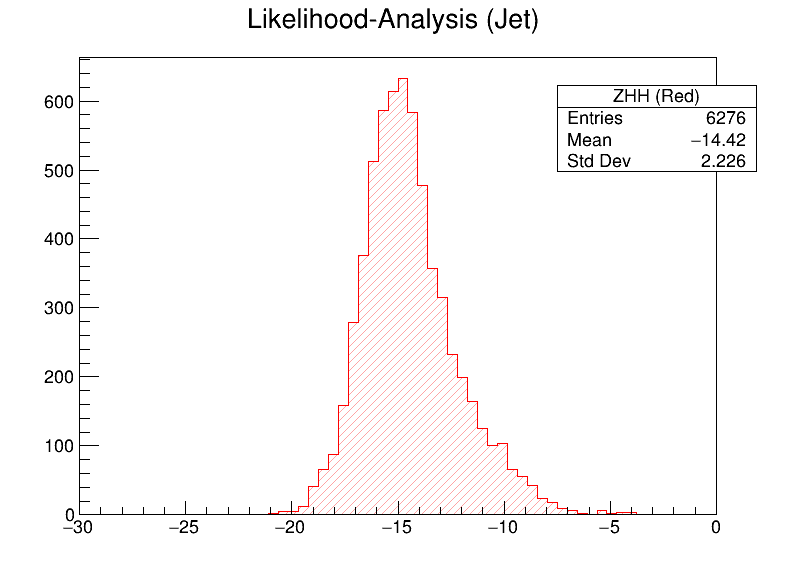

In [102]:
canv = ROOT.TCanvas("c_name", "c_title", 800, 600)
hist_zhh = ROOT.TH1D("ZHH (Red)", "Likelihood-Analysis (Jet)", 64, -30, 0)

llr = data_cut["llr"]
ttype = data_cut["true_type"]
for i in range(0, len(llr)):
    if ttype[i] == "zhh":
        hist_zhh.Fill(llr[i])

hist_zhh.SetFillStyle(3004)
hist_zhh.SetFillColorAlpha(ROOT.kRed, 0.35)
hist_zhh.SetLineColor(ROOT.kRed)

hist_zhh.Draw()
canv.Draw()

ROOT.gPad.Update()

# Adjust statsbox; possible only after drawing
# See https://root.cern.ch/doc/master/classTPaveStats.html
statsbox_zhh = hist_zhh.FindObject("stats")
statsbox_zhh.SetX1NDC(0.7)
statsbox_zhh.SetX2NDC(0.95)
statsbox_zhh.SetY1NDC(0.7)
statsbox_zhh.SetY2NDC(0.85)

In [ ]:
canv = ROOT.TCanvas("c_name", "c_title", 800, 600)
hist_zzh = ROOT.TH1D("ZZH (Blue)", "Likelihood-Analysis (MCParticle)", 64, -30, 0)
hist_zhh = ROOT.TH1D("ZHH (Red)", "Likelihood-Analysis", 64, -30, 0)

llr = data_cut["llr"]
ttype = data_cut["true_type"]
for i in range(0, len(llr)):
    if ttype[i] == "zzh":
        hist_zzh.Fill(llr[i])
    elif ttype[i] == "zhh":
        hist_zhh.Fill(llr[i])

hist_zzh.SetFillStyle(3004)
hist_zzh.SetFillColorAlpha(ROOT.kBlue, 0.35)
hist_zzh.SetLineColor(ROOT.kBlue)

hist_zhh.SetFillStyle(3004)
hist_zhh.SetFillColorAlpha(ROOT.kRed, 0.35)
hist_zhh.SetLineColor(ROOT.kRed)

hist_zzh.Draw()
hist_zhh.Draw("sames")
canv.Draw()

ROOT.gPad.Update()

# Adjust statsbox; possible only after drawing
# See https://root.cern.ch/doc/master/classTPaveStats.html
statsbox_zhh = hist_zhh.FindObject("stats")
statsbox_zhh.SetX1NDC(0.7)
statsbox_zhh.SetX2NDC(0.95)
statsbox_zhh.SetY1NDC(0.7)
statsbox_zhh.SetY2NDC(0.85)

statsbox_zzh = hist_zzh.FindObject("stats")
statsbox_zhh.GetListOfLines()[1].SetTextColor(ROOT.kRed)
statsbox_zzh.SetX1NDC(0.7)
statsbox_zzh.SetX2NDC(0.95)
statsbox_zzh.SetY1NDC(0.5)
statsbox_zzh.SetY2NDC(0.65)

Text(0.5, 1.0, 'ZHH vs ZZH LR')

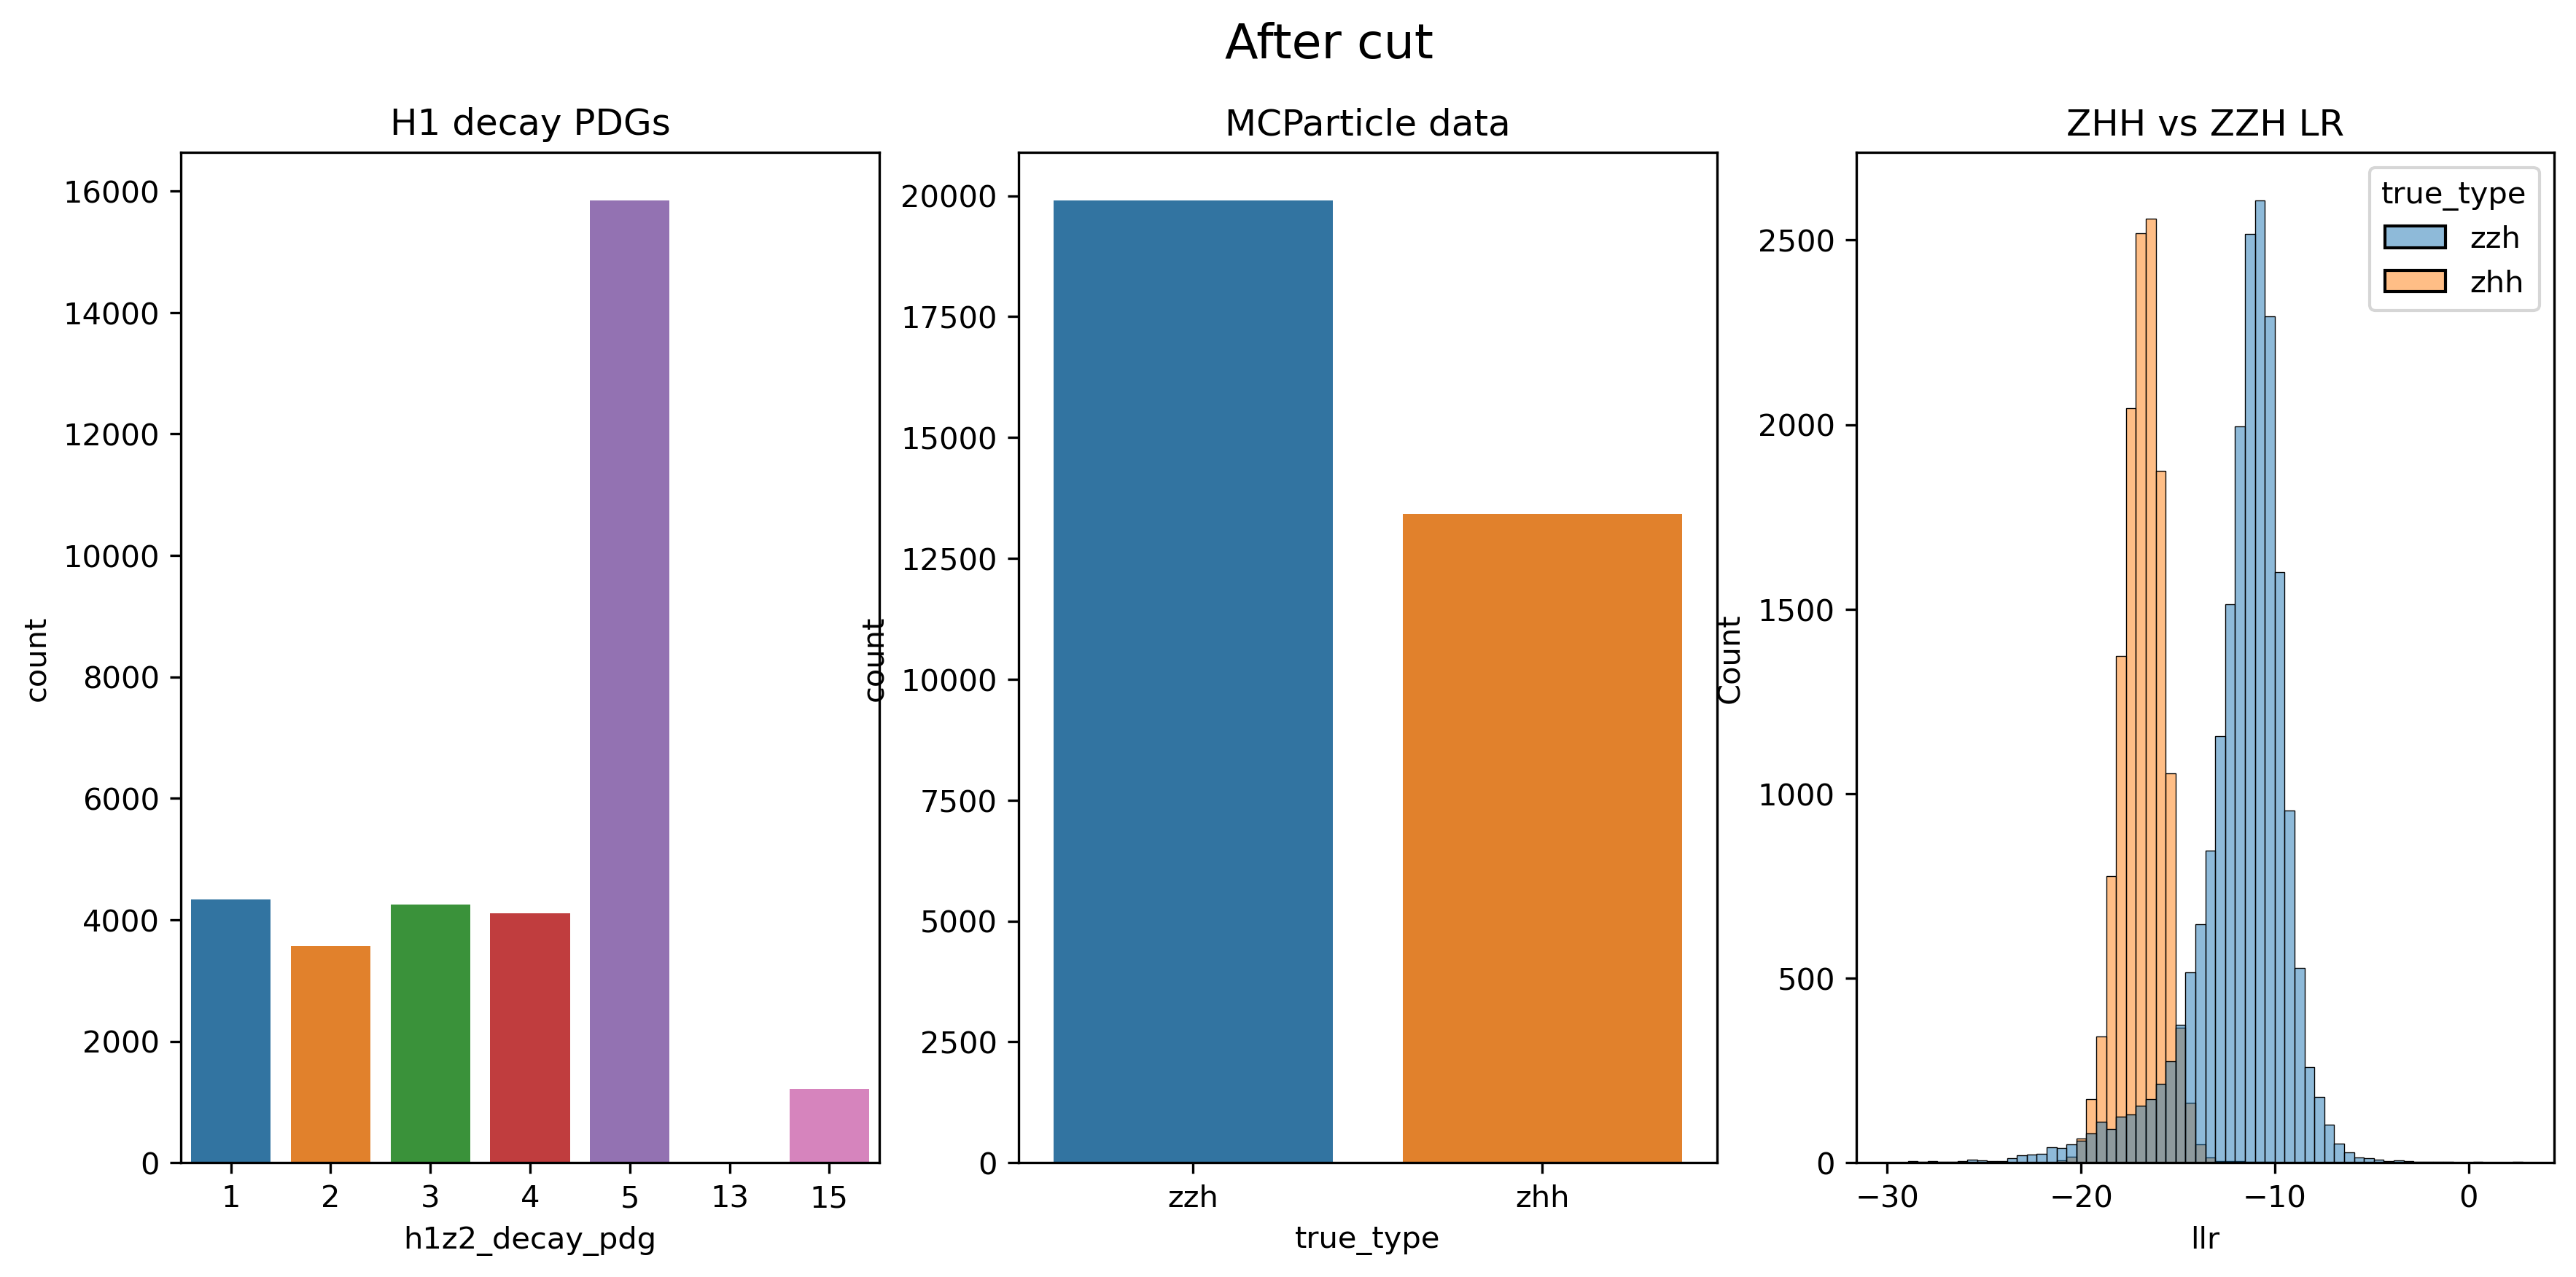

In [17]:
d = data_cut
fig, axes = plt.subplots(1,3, figsize=(14, 6), dpi=300)
fig.suptitle("After cut", fontsize=16)

ax = sns.countplot(d, x="h1z2_decay_pdg", ax=axes[0])
ax.set_title("H1 decay PDGs")

ax = sns.countplot(d, x="true_type", ax=axes[1])
ax.set_title("MCParticle data")

ax = sns.histplot(d, x="llr", hue="true_type", bins=64, ax=axes[2])
ax.set_title("ZHH vs ZZH LR")

In [14]:
true_zhh = data_cut[data_cut["is_zhh"] == 1]
true_zzh = data_cut[data_cut["is_zzh"] == 1]

In [15]:
print(true_zhh.shape[0], true_zzh.shape[0])

13419 19900


In [20]:
true_zhh_split = split_event_tree(true_zhh)
true_zzh_split = split_event_tree(true_zzh)

Text(0.5, 1.0, 'True ZHH MCParticles')

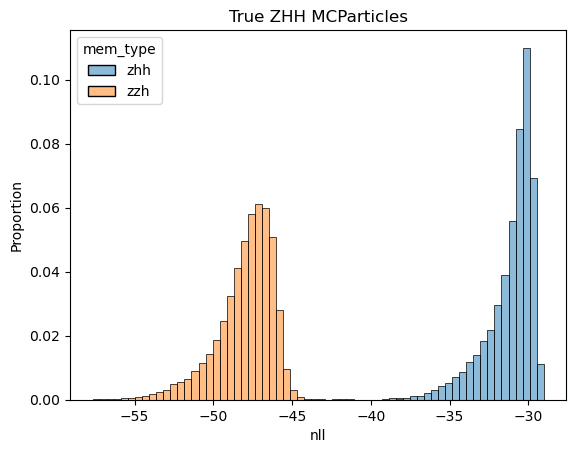

In [124]:
ax = sns.histplot(true_zhh_split, x="nll", hue="mem_type", bins=64, stat="proportion")
ax.set_title("True ZHH MCParticles")

In [128]:
true_zzh_split.reset_index(drop=True, inplace=True)
true_zzh_split

,run,event,is_zhh,is_zzh,h1_decay_pdg,z2_decay_pdg,sigma,zhh_sigmall,zhh_sigmalr,zhh_sigmarl,...,zzh_z2f2_pz,zzh_h_e,zzh_h_px,zzh_h_py,zzh_h_pz,true_type,h1z2_decay_pdg,nll,llr,mem_type
0,403011,1,0,1,0.0,3.0,7.344602e-14,6.965651e-14,3.789516e-15,3.805584e-15,...,124.031075,157.041733,72.794846,-53.599247,-29.413172,zzh,3,-30.242226,-12.641044,zhh
1,403011,2,0,1,0.0,3.0,4.030331e-15,3.575435e-15,4.548957e-16,4.571881e-16,...,11.577676,207.198273,-61.250061,-57.741375,142.198761,zzh,3,-33.144928,-13.411046,zhh
2,403011,3,0,1,0.0,4.0,5.704280e-14,2.816861e-14,2.887418e-14,2.887788e-14,...,0.089793,131.937668,35.247631,13.085950,19.206999,zzh,4,-30.494975,-9.337396,zhh
3,403011,4,0,1,0.0,4.0,5.946260e-15,1.461537e-15,4.484724e-15,4.473190e-15,...,-30.268082,220.370789,23.868135,-177.702896,-28.111895,zzh,4,-32.756014,-11.228584,zhh
4,403011,5,0,1,0.0,5.0,1.256231e-14,1.136108e-14,1.201230e-15,1.202365e-15,...,61.523773,139.716232,12.830882,56.313324,-23.660160,zzh,5,-32.008075,-16.234907,zhh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39795,403011,19896,0,1,NaN,NaN,2.275090e-18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,zzh,5,-40.624512,-10.832258,zzh
39796,403011,19897,0,1,NaN,NaN,6.323993e-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,zzh,1,-44.207351,-11.126942,zzh
39797,403011,19898,0,1,NaN,NaN,2.782756e-22,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,zzh,2,-49.633430,-10.867312,zzh
39798,403011,19899,0,1,NaN,NaN,6.431234e-19,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,zzh,2,-41.887950,-11.220890,zzh


Text(0.5, 1.0, 'True ZZH MCParticles')

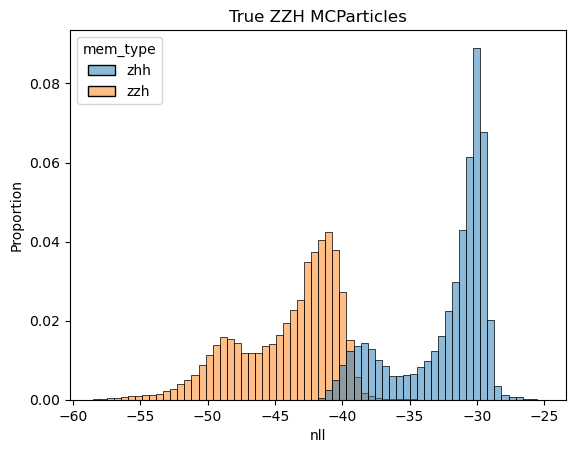

In [129]:
ax = sns.histplot(true_zzh_split, x="nll", hue="mem_type", bins=64, stat="proportion")
ax.set_title("True ZZH MCParticles")